Download the BMI Dataset. We will Demonstrate the cosine attack using  'BMI' dataset. This data frame contains the following columns:

Gender : Male / Female

Height : Number (cm)

Weight : Number (Kg)

Index :
0 - Extremely Weak ,
1 - Weak ,
2 - Normal ,
3 - Overweight ,
4 - Obesity ,
5 - Extreme Obesity

In [11]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
# Based on the dataset handle, assuming a CSV file exists with a similar name.
file_path = "bmi.csv" # Replace with the actual file name if different

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "yasserh/bmidataset",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

#print("First 5 records:", df.head())

/tmp/ipython-input-2376673547.py:11: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


**Step-1)**

Get the training data only and name it as X (only Gender , Height and Weight) and Repair X so that Feature : 'Gender' , for male and female (male = 1 and female = -1)

In [12]:
# Features (training data): just Gender, Height, Weight
import numpy as np
X = df[['Gender', 'Height', 'Weight']].copy()


X['Gender'] = np.where(X['Gender'].str.strip().str.lower() == 'male', 1, -1)

X_new = X.to_numpy()

#print("Shape of NumPy array:", X_new.shape)
#print("First 5 rows as NumPy array:\n", X_new[:5])

**Step-2**

i) select 3 buffer points as list1 (without replacement)

ii) select one data point as list2 (1d array) (without replacement, unknown data point)

iii) find the cosine similarities between list_1 and list_2 and store them in list_3

In [13]:
import numpy as np

# choose 3 samples (store it in list_1)
indices = np.random.choice(X_new.shape[0], 3, replace=False)
list_1 = X_new[indices]

# choose 1 sample (store it in list_2) --------> ( Unknown data point )
index = np.random.choice(X_new.shape[0], 1, replace=False)[0]
list_2 = X_new[index]
print("Indices for three samples:", indices)
print("Three samples:\n", list_1)
print("\nIndex for one sample:", index)
print("One sample:\n", list_2)

Indices for three samples: [  7 393  96]
Three samples:
 [[  1 154 111]
 [ -1 183  87]
 [  1 142  69]]

Index for one sample: 51
One sample:
 [ -1 176  54]


In [14]:
import numpy as np

#Normalize buffer points(list_1) and make them unit vector
axes = np.array([v / np.linalg.norm(v) for v in list_1])
#print("Normalized axes:\n", axes)

norm_list_2 = np.linalg.norm(list_2)

# compute cosine similarity between list_2(unknown data point) with each row in list_1
list_3 = np.array([
    np.dot(row, list_2) / (np.linalg.norm(row) * norm_list_2)
    for row in list_1
])

print("Cosine similarities (list_3):\n", list_3)

Cosine similarities (list_3):
 [0.94700721 0.98934908 0.98800187]


**Step_3**

i) define a function name as "compute_direction"

input - list1 , list3

output - direction of the intersection

**This function will give a Unit vector as an output which is nothing but the direction of intersection between three buffer points**

In [15]:
import numpy as np
from itertools import product

def compute_direction(axes, list_3, tol=1e-6):
    """
    Compute the intersection direction of three cones.

    Args:
        list_1 (ndarray): shape (3, d). The three axis vectors (d = dimension, here 3).
        list_3 (ndarray): shape (3,). Cosine similarity values = cos(theta_i).
        tol (float): tolerance for unit norm check.

    Returns:
        direction (ndarray): a valid unit direction vector (if found).
    """

    # Step 1: Build matrix A from the normalized vector of list_1
    A = axes
    print(f"This is\n :",A)
    print("\n")

    #step-2
    # Only for all positive and all negative sign combinations
    sign_combos = np.array([[1,1,1], [-1,-1,-1]])

    for signs in sign_combos:
        s = np.array(signs)
        b_s = s * list_3
        print(f"this is s: {s}, b_s: {b_s}")

        # Solve A u = b_s
        try:
            u = np.linalg.solve(A, b_s)
        except np.linalg.LinAlgError:
            continue  # skip if singular

        # Step 4: Check if u is unit vector (≈ 1)
        if abs(np.linalg.norm(u) - 1) < tol:
          final_u = u  # return the first valid direction
          final_s = s

    return final_u
    raise ValueError("No valid unit direction found for given inputs.")

In [16]:
#find the direction
# pass axes (normalized vector of list_1) and list_3
direction = compute_direction(axes , list_3)
print("Intersection direction vector:\n", direction)


This is
 : [[ 0.00526768  0.81122323  0.58471285]
 [-0.0049351   0.90312301  0.42935356]
 [ 0.00633394  0.89941898  0.43704162]]


this is s: [1 1 1], b_s: [0.94700721 0.98934908 0.98800187]
this is s: [-1 -1 -1], b_s: [-0.94700721 -0.98934908 -0.98800187]
Intersection direction vector:
 [ 0.00543182 -0.95599949 -0.29331803]


**Step_4**

i) Get the direction in form of(x_1 , x_2 , x_3) , so make it (x_1/x_1 , x_2/x_1 , x_3/x-1)

ii) direction_new = (x_1/x_1 , x_2/x_1 , x_3/x_1)

ii) now compare direction new to normlized list_2 vector

In [17]:
x1, x2, x3 = direction
print(x1, x2, x3)

direction_new = np.array([x1 / x1, x2 / x1, x3 / x1])
if(direction_new[1]<0 and direction_new[2]<0):
  direction_new = -1*direction_new
print("direction_new:", direction_new)

0.005431815301791652 -0.9559994931130069 -0.2933180262960354
direction_new: [ -1. 176.  54.]


In [18]:
# check if reconstructed vector from the direction vector(unit norm) is same as the unknown data point or not

if(np.allclose(direction_new,list_2, atol=1e-6)):
  print("data point is same as unknown data point")

data point is same as unknown data point


**Visualization Of the Intersection of Buffer Points with Unknown Data point**

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_cone(ax, axis, theta, color):
    v = np.array([1,0,0]) if abs(axis[0])<0.9 else np.array([0,1,0])
    v = v - v.dot(axis)*axis
    v /= np.linalg.norm(v)
    w = np.cross(axis, v)

    alpha = np.linspace(0, 2*np.pi, 60)
    h = np.linspace(0, 1, 30)
    H, A = np.meshgrid(h, alpha)

    R = H*np.tan(theta)
    X = H*axis[0] + R*np.cos(A)*v[0] + R*np.sin(A)*w[0]
    Y = H*axis[1] + R*np.cos(A)*v[1] + R*np.sin(A)*w[1]
    Z = H*axis[2] + R*np.cos(A)*v[2] + R*np.sin(A)*w[2]

    ax.plot_surface(X, Y, Z, color=color, alpha=0.3, linewidth=0)

def plot_cones_and_intersection(axes_unit, cos_thetas):
    thetas = np.arccos(cos_thetas)
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')

    colors = ['red','green','blue']
    for axis,theta,c in zip(axes_unit, thetas, colors):
        plot_cone(ax, axis, theta, c)

    # compute + plot intersection line (u)
    A = np.vstack(axes_unit)
    list_3 = np.arccos(cos_thetas)  # or whatever you used earlier
    b = cos_thetas
    u, *_ = np.linalg.lstsq(A, b, rcond=None)
    u /= np.linalg.norm(u)

    L = np.linspace(-1.5, 1.5, 100)
    ax.plot(L*u[0], L*u[1], L*u[2], 'k-', linewidth=3, label='Intersection line')

    lim = 1
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.set_zlim(-lim, lim)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    plt.show()


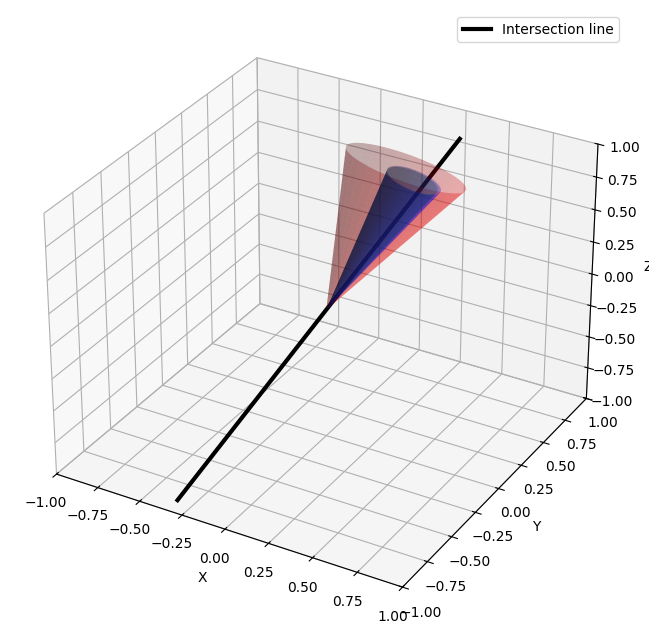

In [20]:
# Get a Visualization of the cone intersections
plot_cones_and_intersection(axes,list_3)